# Kaggle GI Tract Train

Using code snippets from:
https://www.kaggle.com/code/yiheng/3d-solution-with-monai-produce-3d-data/notebook
https://www.kaggle.com/code/israrahmed919/createmasksopencv
https://www.kaggle.com/code/clemchris/gi-seg-pytorch-train-infer


Consider:
https://github.com/catalyst-team/catalyst - training loop - was buggy so abandoned the idea.

https://torchio.readthedocs.io/data/image.html - has simulation of intensity artifacts due to MRI magnetic field inhomogeneity (bias) or k-space motion artifacts.


https://www.kaggle.com/code/yiheng/50-times-faster-way-get-hausdorff-with-monai 



**Notes**
* create simple model for first submission


In [1]:
import os, glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from einops import rearrange, reduce, repeat

from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

from pathlib import Path

#DATASET_FOLDER = "/kaggle/input/uw-madison-gi-tract-image-segmentation"
DATASET_FOLDER = Path("/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation")
TRAIN_FOLDER = DATASET_FOLDER/"train"

MODEL_FOLDER = DATASET_FOLDER/"kaggle models"
os.makedirs(MODEL_FOLDER, exist_ok=True)



# Data

## Process the Metadata

In [2]:
df2d = pd.read_csv(DATASET_FOLDER/"df2d_metadata.csv")
display(df2d.head())

,Unnamed: 0,large_bowel,small_bowel,stomach,id,case_id_str,case_id,day_num_str,day_num,slice_id,...,match,subpath,filename,im_height,im_width,im_pixel_height,im_pixel_width,slice_thickness,segmentations,fold
0,0,NaN,NaN,NaN,case101_day20_slice_0001,case101,101,day20,20,slice_0001,...,case101/case101_day20/scans/slice_0001,case101/case101_day20/scans/slice_0001_266_266...,slice_0001_266_266_1.50_1.50.png,266,266,1.5,1.5,3.0,False,4.0
1,1,NaN,NaN,NaN,case101_day20_slice_0002,case101,101,day20,20,slice_0002,...,case101/case101_day20/scans/slice_0002,case101/case101_day20/scans/slice_0002_266_266...,slice_0002_266_266_1.50_1.50.png,266,266,1.5,1.5,3.0,False,4.0
2,2,NaN,NaN,NaN,case101_day20_slice_0003,case101,101,day20,20,slice_0003,...,case101/case101_day20/scans/slice_0003,case101/case101_day20/scans/slice_0003_266_266...,slice_0003_266_266_1.50_1.50.png,266,266,1.5,1.5,3.0,False,4.0
3,3,NaN,NaN,NaN,case101_day20_slice_0004,case101,101,day20,20,slice_0004,...,case101/case101_day20/scans/slice_0004,case101/case101_day20/scans/slice_0004_266_266...,slice_0004_266_266_1.50_1.50.png,266,266,1.5,1.5,3.0,False,4.0
4,4,NaN,NaN,NaN,case101_day20_slice_0005,case101,101,day20,20,slice_0005,...,case101/case101_day20/scans/slice_0005,case101/case101_day20/scans/slice_0005_266_266...,slice_0005_266_266_1.50_1.50.png,266,266,1.5,1.5,3.0,False,4.0


## Create a Pytorch Dataset

In [3]:
from torchvision.transforms import PILToTensor

In [4]:
class Dataset_from_df(torch.utils.data.Dataset):
    def __init__(self, df, path, transform=None):
        self.df = df
        self.path = path
        self.transform = transform
        self.pil_to_tensor = PILToTensor()

        
    def __len__(self):
        return self.df.shape[0]
    
    #Helper Function to decode RLE
    def _rle_decode_float(self,mask_rle, shape, color_val=1):
        '''
        mask_rle: run-length as string formated (start length)
        shape: (height,width) of array to return 
        Returns numpy array, color_val - mask, 0 - background

        '''
        s = mask_rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        #img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)

        img = torch.zeros(shape[1]*shape[2])
        for lo, hi in zip(starts, ends):
            img[lo : hi] = color_val
        return img.reshape(shape)    
    
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        
        img_path = self.path/row.subpath
        # Use PIL Image to read the image files since it handles 32 bit images
        img = self.pil_to_tensor(Image.open(img_path))
        #print(img.shape)
        
        lb_class_seg = row.large_bowel
        sb_class_seg = row.small_bowel
        st_class_seg = row.stomach
        
        
        mask = torch.zeros((3, img.shape[1], img.shape[2]))

        if type(lb_class_seg) is str:
            mask[0,:,:] = self._rle_decode_float(lb_class_seg,img.shape,color_val=1)

        if type(sb_class_seg) is str:
            mask[1,:,:] = self._rle_decode_float(sb_class_seg, img.shape,color_val=1)

        if type(st_class_seg) is str:
            mask[2,:,:] = self._rle_decode_float(st_class_seg, img.shape,color_val=1)
        
        
        
        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)
    
        
        
        return {
            "image": img,
            "mask": mask,
        }
        
        
    
    


In [5]:
dataset = Dataset_from_df(df2d[df2d['segmentations']],TRAIN_FOLDER)

In [6]:
dataset[665]['image'].max()

tensor(10672, dtype=torch.int32)

In [7]:
def plot_data(d):
    ratio = 1.0
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.imshow(d['image'].squeeze().numpy(),cmap='gray', aspect=ratio)
    plt.title(f"Image Shape= {d['image'].shape}")
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(rearrange(d['mask'].numpy(),'c h w -> h w c'), aspect=ratio)
    plt.title(f"Mask Shape = {d['mask'].shape}")
    plt.axis('off')

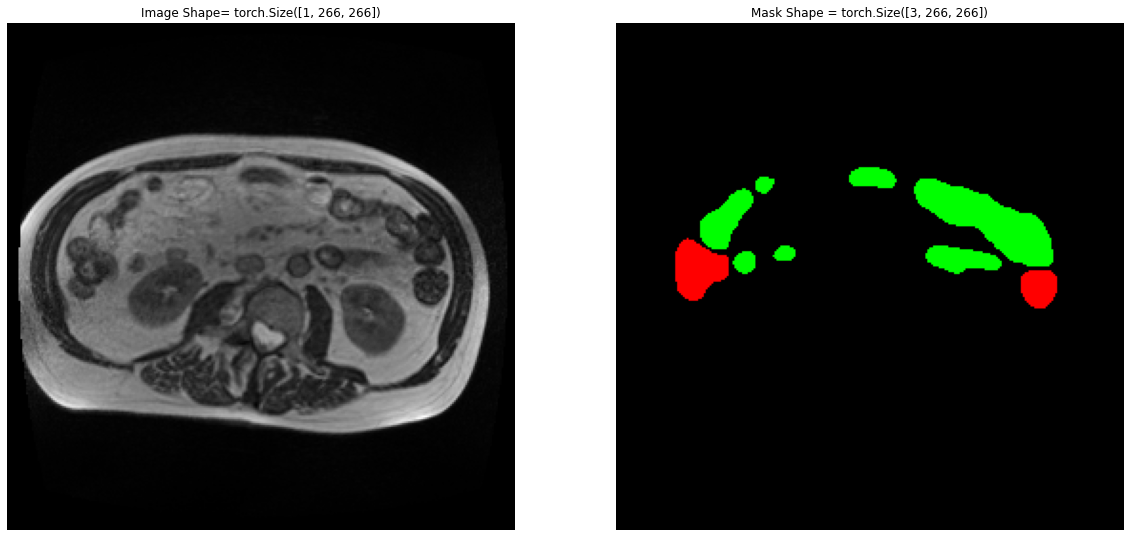

In [8]:
plot_data(dataset[665])

### With n fold cross validation we need a dataset for each fold

In [9]:
def prepare_datasets(df, fold, train_transforms, valid_transforms):
    train_df = df.query("fold!=@fold").query("segmentations==True").reset_index(drop=True)
    valid_df = df.query("fold==@fold").query("segmentations==True").reset_index(drop=True)

    train_dataset = Dataset_from_df(train_df,TRAIN_FOLDER, transform=train_transforms)
    valid_dataset = Dataset_from_df(valid_df,TRAIN_FOLDER, transform=valid_transforms)
    
    return train_dataset, valid_dataset

# Training

In [10]:
import segmentation_models_pytorch as smp
from tqdm.notebook import tqdm

## Loss Functions and Metrics

In [11]:
JaccardLoss = smp.losses.JaccardLoss(mode='multilabel')
DiceLoss    = smp.losses.DiceLoss(mode='multilabel')
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss  = smp.losses.LovaszLoss(mode='multilabel', per_image=False)
TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False)

def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

def criterion(y_pred, y_true):
    return 0.5*BCELoss(y_pred, y_true) + 0.5*TverskyLoss(y_pred, y_true)

## Training Loops

In [12]:
def trainfp32(epoch, train_dataloader, optimizer, loss_fn, lr_scheduler,
              metric_fn, model):


    model.train()

    training_loss = 0
    metric = 0

    pbar = tqdm(total=len(train_dataloader))

    for batch in train_dataloader:

        optimizer.zero_grad()

        images, masks = batch['image'], batch['mask']

        images = images.cuda(non_blocking=True)
        masks = masks.cuda(non_blocking=True)

        #print(images.shape, masks.shape)
        
        output = model(images)

        loss = loss_fn(output, masks)


        loss.backward()

        optimizer.step()

        lr_scheduler.step()

        with torch.no_grad():
            training_loss += loss.data.item() * images.size(0)
            y_pred = torch.nn.Sigmoid()(output)
            metric += metric_fn(masks,y_pred) * images.size(0)

        pbar.update(1)
    pbar.close()
    torch.cuda.empty_cache()
    training_loss /= len(train_dataloader.dataset)
    metric /= len(train_dataloader.dataset)
    return training_loss, metric

In [13]:
def validatefp32(valid_dataloader, loss_fn, metric_fn, model):
    validation_loss = 0
    metric = 0
    model.eval()
    pbar = tqdm(total=len(valid_dataloader))
    for batch in valid_dataloader:
        images, masks = batch['image'], batch['mask']

        images = images.cuda(non_blocking=True)
        masks = masks.cuda(non_blocking=True)

        output = model(images)
        with torch.no_grad():
            loss = loss_fn(output,masks)
            validation_loss += loss.data.item() * images.size(0)
            y_pred = torch.nn.Sigmoid()(output)
            metric += metric_fn(masks,y_pred) * images.size(0)
        pbar.update(1)
    pbar.close()
    torch.cuda.empty_cache()
    validation_loss /= len(valid_dataloader.dataset)
    metric /= len(valid_dataloader.dataset)
    return validation_loss, metric

## Training

In [14]:
from torchvision import transforms

In [15]:
train_transforms = transforms.Compose(
    [transforms.CenterCrop((266,266)),
    transforms.ConvertImageDtype(torch.float32),
    transforms.Resize((288,288),interpolation=transforms.InterpolationMode.BICUBIC)])

In [16]:
valid_transforms = transforms.Compose(
    [transforms.CenterCrop((266,266)),
    transforms.ConvertImageDtype(torch.float32),
    transforms.Resize((288,288),interpolation=transforms.InterpolationMode.BICUBIC)])  # multiple of 32 for UUnet

In [17]:
init_lr = .001
epochs = 20
loss_fn = criterion
metric_fn = dice_coef
n_folds = int(df2d['fold'].max()) + 1

In [18]:
for fold in range(0,n_folds):
    
    model = smp.Unet(
    encoder_name="efficientnet-b0",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3)                    # model output channels (number of classes in your dataset)
    model.cuda()
    model_name_base = "Unet-1"

    
    train_dataset, valid_dataset = prepare_datasets(df2d, fold, train_transforms, valid_transforms)
    
    train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                   batch_size=8,
                                                   num_workers=10,
                                                   pin_memory=True,
                                                   shuffle=True)

    valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                                   batch_size=8,
                                                   num_workers=10,
                                                   pin_memory=True,
                                                   shuffle=True)
    
    
    
    optimizer = torch.optim.Adam(model.parameters(), lr=init_lr,weight_decay = 1e-6)
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=init_lr, steps_per_epoch=len(train_dataloader),
                                                  epochs=epochs)
    
    
    best_validation_loss = 999

    for epoch in range(1, epochs + 1):

        lr = lr_scheduler.get_last_lr()
        print('Fold: {}, Epoch: {}, LR: {:.3e}'.format(fold, epoch, lr[0]), end="--")

        training_loss, training_metric = trainfp32(epoch,
                                                   train_dataloader,
                                                   optimizer,
                                                   loss_fn,
                                                   lr_scheduler,
                                                   metric_fn,
                                                   model)

        print('Training-- Loss: {:.4f}, Metric: {:.3f}'.format(
            training_loss, training_metric),
              end=',')
        validation_loss, validation_metric = validatefp32(valid_dataloader,
                                                          loss_fn,
                                                          metric_fn,
                                                          model)

        #if validation_loss < best_validation_loss:
            #model_out_str = str(model_out_path/(model_name_base+"_best.pth"))
            #torch.save(model.state_dict(), model_out_str)

        print('Validation-- Loss: {:.4f}, Metric = {:.3f}'.format(
            validation_loss, validation_metric))
        
    model_out_str = str(MODEL_FOLDER/("fold-" + str(fold) + '-' + model_name_base + "-1.pth"))
    print(model_out_str)
    torch.save(model.state_dict(), model_out_str)

Fold: 0, Epoch: 1, LR: 4.000e-05--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.5499, Metric: 0.252,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.5464, Metric = 0.269
Fold: 0, Epoch: 2, LR: 1.043e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.1786, Metric: 0.707,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.8095, Metric = 0.173
Fold: 0, Epoch: 3, LR: 2.800e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.1243, Metric: 0.781,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.6721, Metric = 0.147
Fold: 0, Epoch: 4, LR: 5.201e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.1095, Metric: 0.802,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 1.5500, Metric = 0.106
Fold: 0, Epoch: 5, LR: 7.601e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0983, Metric: 0.826,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.8328, Metric = 0.318
Fold: 0, Epoch: 6, LR: 9.358e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0994, Metric: 0.821,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.7356, Metric = 0.318
Fold: 0, Epoch: 7, LR: 1.000e-03--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0827, Metric: 0.856,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.6722, Metric = 0.155
Fold: 0, Epoch: 8, LR: 9.874e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0817, Metric: 0.859,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.8024, Metric = 0.269
Fold: 0, Epoch: 9, LR: 9.505e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0730, Metric: 0.876,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.6947, Metric = 0.212
Fold: 0, Epoch: 10, LR: 8.909e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0685, Metric: 0.886,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 1.9674, Metric = 0.318
Fold: 0, Epoch: 11, LR: 8.117e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0646, Metric: 0.892,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.7954, Metric = 0.271
Fold: 0, Epoch: 12, LR: 7.169e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0609, Metric: 0.900,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.6708, Metric = 0.142
Fold: 0, Epoch: 13, LR: 6.112e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0560, Metric: 0.910,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.9205, Metric = 0.318
Fold: 0, Epoch: 14, LR: 4.999e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0522, Metric: 0.916,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.9255, Metric = 0.316
Fold: 0, Epoch: 15, LR: 3.887e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0497, Metric: 0.921,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.6645, Metric = 0.318
Fold: 0, Epoch: 16, LR: 2.830e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0469, Metric: 0.927,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.6651, Metric = 0.339
Fold: 0, Epoch: 17, LR: 1.882e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0443, Metric: 0.932,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.7149, Metric = 0.292
Fold: 0, Epoch: 18, LR: 1.090e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0425, Metric: 0.936,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.4379, Metric = 0.267
Fold: 0, Epoch: 19, LR: 4.949e-05--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0410, Metric: 0.938,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.2825, Metric = 0.609
Fold: 0, Epoch: 20, LR: 1.252e-05--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0406, Metric: 0.939,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1437, Metric = 0.780
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-0-Unet-1-1.pth
Fold: 1, Epoch: 1, LR: 4.000e-05--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.5130, Metric: 0.315,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.8003, Metric = 0.131
Fold: 1, Epoch: 2, LR: 1.043e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.1819, Metric: 0.698,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 1.4571, Metric = 0.263
Fold: 1, Epoch: 3, LR: 2.800e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.1330, Metric: 0.763,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.6687, Metric = 0.113
Fold: 1, Epoch: 4, LR: 5.201e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.1151, Metric: 0.793,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.5953, Metric = 0.306
Fold: 1, Epoch: 5, LR: 7.601e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.1031, Metric: 0.815,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.5951, Metric = 0.293
Fold: 1, Epoch: 6, LR: 9.358e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0958, Metric: 0.831,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.6157, Metric = 0.146
Fold: 1, Epoch: 7, LR: 1.000e-03--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0886, Metric: 0.841,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.9938, Metric = 0.306
Fold: 1, Epoch: 8, LR: 9.874e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0793, Metric: 0.864,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.7459, Metric = 0.306
Fold: 1, Epoch: 9, LR: 9.505e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0739, Metric: 0.873,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.7907, Metric = 0.306
Fold: 1, Epoch: 10, LR: 8.909e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0746, Metric: 0.869,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.7942, Metric = 0.300
Fold: 1, Epoch: 11, LR: 8.117e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0653, Metric: 0.890,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.6320, Metric = 0.253
Fold: 1, Epoch: 12, LR: 7.169e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0617, Metric: 0.898,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 1.5139, Metric = 0.306
Fold: 1, Epoch: 13, LR: 6.112e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0584, Metric: 0.903,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.9509, Metric = 0.306
Fold: 1, Epoch: 14, LR: 4.999e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0548, Metric: 0.911,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.6203, Metric = 0.306
Fold: 1, Epoch: 15, LR: 3.887e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0512, Metric: 0.919,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 1.1225, Metric = 0.292
Fold: 1, Epoch: 16, LR: 2.830e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0480, Metric: 0.924,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.5918, Metric = 0.305
Fold: 1, Epoch: 17, LR: 1.882e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0459, Metric: 0.928,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.5579, Metric = 0.201
Fold: 1, Epoch: 18, LR: 1.090e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0439, Metric: 0.933,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.6327, Metric = 0.292
Fold: 1, Epoch: 19, LR: 4.949e-05--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0424, Metric: 0.935,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.2196, Metric = 0.667
Fold: 1, Epoch: 20, LR: 1.252e-05--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0421, Metric: 0.936,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1356, Metric = 0.786
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-1-Unet-1-1.pth
Fold: 2, Epoch: 1, LR: 4.000e-05--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.5185, Metric: 0.328,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.6260, Metric = 0.149
Fold: 2, Epoch: 2, LR: 1.043e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.1664, Metric: 0.727,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.5773, Metric = 0.332
Fold: 2, Epoch: 3, LR: 2.800e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.1254, Metric: 0.779,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.5934, Metric = 0.332
Fold: 2, Epoch: 4, LR: 5.201e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.1093, Metric: 0.806,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.6142, Metric = 0.269
Fold: 2, Epoch: 5, LR: 7.601e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.1012, Metric: 0.822,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.6495, Metric = 0.332
Fold: 2, Epoch: 6, LR: 9.358e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0925, Metric: 0.839,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.6417, Metric = 0.332
Fold: 2, Epoch: 7, LR: 1.000e-03--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0855, Metric: 0.851,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.6624, Metric = 0.332
Fold: 2, Epoch: 8, LR: 9.874e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0807, Metric: 0.862,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.9069, Metric = 0.332
Fold: 2, Epoch: 9, LR: 9.505e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0712, Metric: 0.882,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.6021, Metric = 0.332
Fold: 2, Epoch: 10, LR: 8.909e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0728, Metric: 0.874,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.8199, Metric = 0.332
Fold: 2, Epoch: 11, LR: 8.117e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0654, Metric: 0.892,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.7282, Metric = 0.332
Fold: 2, Epoch: 12, LR: 7.169e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0615, Metric: 0.900,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.6165, Metric = 0.332
Fold: 2, Epoch: 13, LR: 6.112e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0568, Metric: 0.909,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.6919, Metric = 0.309
Fold: 2, Epoch: 14, LR: 4.999e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0535, Metric: 0.915,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.6731, Metric = 0.289
Fold: 2, Epoch: 15, LR: 3.887e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0509, Metric: 0.919,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 1.0557, Metric = 0.263
Fold: 2, Epoch: 16, LR: 2.830e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0481, Metric: 0.926,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.6112, Metric = 0.205
Fold: 2, Epoch: 17, LR: 1.882e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0453, Metric: 0.931,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.5850, Metric = 0.334
Fold: 2, Epoch: 18, LR: 1.090e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0437, Metric: 0.935,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.6656, Metric = 0.319
Fold: 2, Epoch: 19, LR: 4.949e-05--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0424, Metric: 0.937,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.3199, Metric = 0.477
Fold: 2, Epoch: 20, LR: 1.253e-05--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0421, Metric: 0.938,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1709, Metric = 0.723
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-2-Unet-1-1.pth
Fold: 3, Epoch: 1, LR: 4.000e-05--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.4534, Metric: 0.367,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.9090, Metric = 0.290
Fold: 3, Epoch: 2, LR: 1.043e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.1740, Metric: 0.707,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.6270, Metric = 0.206
Fold: 3, Epoch: 3, LR: 2.800e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.1325, Metric: 0.769,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.8040, Metric = 0.328
Fold: 3, Epoch: 4, LR: 5.201e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.1157, Metric: 0.798,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.6275, Metric = 0.328
Fold: 3, Epoch: 5, LR: 7.601e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.1059, Metric: 0.814,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.6237, Metric = 0.328
Fold: 3, Epoch: 6, LR: 9.358e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0985, Metric: 0.828,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.6756, Metric = 0.328
Fold: 3, Epoch: 7, LR: 1.000e-03--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0919, Metric: 0.841,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.6477, Metric = 0.328
Fold: 3, Epoch: 8, LR: 9.874e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0804, Metric: 0.862,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.6358, Metric = 0.325
Fold: 3, Epoch: 9, LR: 9.505e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0780, Metric: 0.867,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.6929, Metric = 0.328
Fold: 3, Epoch: 10, LR: 8.909e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0712, Metric: 0.880,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.6524, Metric = 0.328
Fold: 3, Epoch: 11, LR: 8.117e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0676, Metric: 0.887,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.6566, Metric = 0.328
Fold: 3, Epoch: 12, LR: 7.169e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0623, Metric: 0.899,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.7052, Metric = 0.328
Fold: 3, Epoch: 13, LR: 6.112e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0598, Metric: 0.902,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.8671, Metric = 0.325
Fold: 3, Epoch: 14, LR: 4.999e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0546, Metric: 0.913,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.6424, Metric = 0.328
Fold: 3, Epoch: 15, LR: 3.887e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0518, Metric: 0.919,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.6936, Metric = 0.328
Fold: 3, Epoch: 16, LR: 2.830e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0489, Metric: 0.924,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.6481, Metric = 0.328
Fold: 3, Epoch: 17, LR: 1.882e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0465, Metric: 0.928,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.6803, Metric = 0.328
Fold: 3, Epoch: 18, LR: 1.090e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0446, Metric: 0.933,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.5696, Metric = 0.325
Fold: 3, Epoch: 19, LR: 4.949e-05--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0432, Metric: 0.935,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.3481, Metric = 0.530
Fold: 3, Epoch: 20, LR: 1.253e-05--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0427, Metric: 0.936,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.1043, Metric = 0.823
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-3-Unet-1-1.pth
Fold: 4, Epoch: 1, LR: 4.000e-05--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.4881, Metric: 0.349,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.5669, Metric = 0.315
Fold: 4, Epoch: 2, LR: 1.043e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.1696, Metric: 0.718,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.6029, Metric = 0.315
Fold: 4, Epoch: 3, LR: 2.800e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.1273, Metric: 0.779,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.6158, Metric = 0.208
Fold: 4, Epoch: 4, LR: 5.201e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.1097, Metric: 0.807,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.5848, Metric = 0.202
Fold: 4, Epoch: 5, LR: 7.601e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.1034, Metric: 0.817,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.6319, Metric = 0.315
Fold: 4, Epoch: 6, LR: 9.358e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0959, Metric: 0.832,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.6420, Metric = 0.187
Fold: 4, Epoch: 7, LR: 1.000e-03--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0854, Metric: 0.852,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.9958, Metric = 0.315
Fold: 4, Epoch: 8, LR: 9.874e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0821, Metric: 0.858,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.8088, Metric = 0.315
Fold: 4, Epoch: 9, LR: 9.505e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0777, Metric: 0.866,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.6645, Metric = 0.315
Fold: 4, Epoch: 10, LR: 8.909e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0704, Metric: 0.883,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.7098, Metric = 0.315
Fold: 4, Epoch: 11, LR: 8.117e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0640, Metric: 0.894,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.6554, Metric = 0.264
Fold: 4, Epoch: 12, LR: 7.169e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0616, Metric: 0.898,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.7052, Metric = 0.315
Fold: 4, Epoch: 13, LR: 6.112e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0563, Metric: 0.910,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.8046, Metric = 0.315
Fold: 4, Epoch: 14, LR: 4.999e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0527, Metric: 0.916,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.7566, Metric = 0.110
Fold: 4, Epoch: 15, LR: 3.887e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0499, Metric: 0.921,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.6858, Metric = 0.226
Fold: 4, Epoch: 16, LR: 2.830e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0465, Metric: 0.928,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.6848, Metric = 0.310
Fold: 4, Epoch: 17, LR: 1.882e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0443, Metric: 0.932,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.5830, Metric = 0.325
Fold: 4, Epoch: 18, LR: 1.090e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0425, Metric: 0.936,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.6828, Metric = 0.314
Fold: 4, Epoch: 19, LR: 4.949e-05--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0415, Metric: 0.938,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.4330, Metric = 0.466
Fold: 4, Epoch: 20, LR: 1.253e-05--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0406, Metric: 0.939,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1406, Metric = 0.774
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-4-Unet-1-1.pth


## Do some trial inference on the validation set

In [19]:
model_name_base = "Unet-1"
model = smp.Unet(
encoder_name="efficientnet-b0",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
classes=3)                    # model output channels (number of classes in your dataset)
model.cuda();

In [20]:
#Select the fold=0 model for this
fold = 0

model_in_str = str(MODEL_FOLDER/("fold-" + str(fold) + '-' + model_name_base + "-1.pth"))
model.load_state_dict(torch.load(model_in_str))

<All keys matched successfully>

In [21]:
train_dataset, valid_dataset = prepare_datasets(df2d, fold, train_transforms, valid_transforms)


valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                               batch_size=8,
                                               num_workers=10,
                                               pin_memory=True,
                                               shuffle=True)

In [22]:
data = next(iter(valid_dataloader))
output = model(data['image'].cuda())

In [23]:
output.max()

tensor(12.7720, device='cuda:0', grad_fn=<MaxBackward1>)

In [24]:
def plot_result(data,output,idx):
    ratio = 1.0
    plt.figure(figsize=(20,20))
    plt.subplot(2,2,1)
    plt.imshow(data['image'][idx].squeeze().numpy(),cmap='gray', aspect=ratio)
    plt.title(f"Image {idx} Shape= {data['image'][idx].shape}")
    plt.axis('off')
    plt.subplot(2,2,2)
    plt.imshow(rearrange(data['mask'][idx].numpy(),'c h w -> h w c'), aspect=ratio)
    plt.title(f"Ground Truth Mask {idx} Shape = {data['mask'][idx].shape}")
    plt.axis('off')
    plt.subplot(2,2,3)
    plt.imshow(rearrange(output[idx].detach().cpu().numpy(),'c h w -> h w c'), aspect=ratio)
    plt.title(f"Predicted Mask {idx} Shape = {output[idx].shape}")
    plt.axis('off')
    plt.subplot(2,2,4)
    plt.imshow(data['image'][idx].squeeze().numpy(),cmap='gray', aspect=ratio)
    plt.imshow(rearrange(output[idx].detach().cpu().numpy(),'c h w -> h w c'), alpha=0.5, aspect=ratio)
    plt.title(f"Predicted Mask {idx} Shape = {output[idx].shape}")
    plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

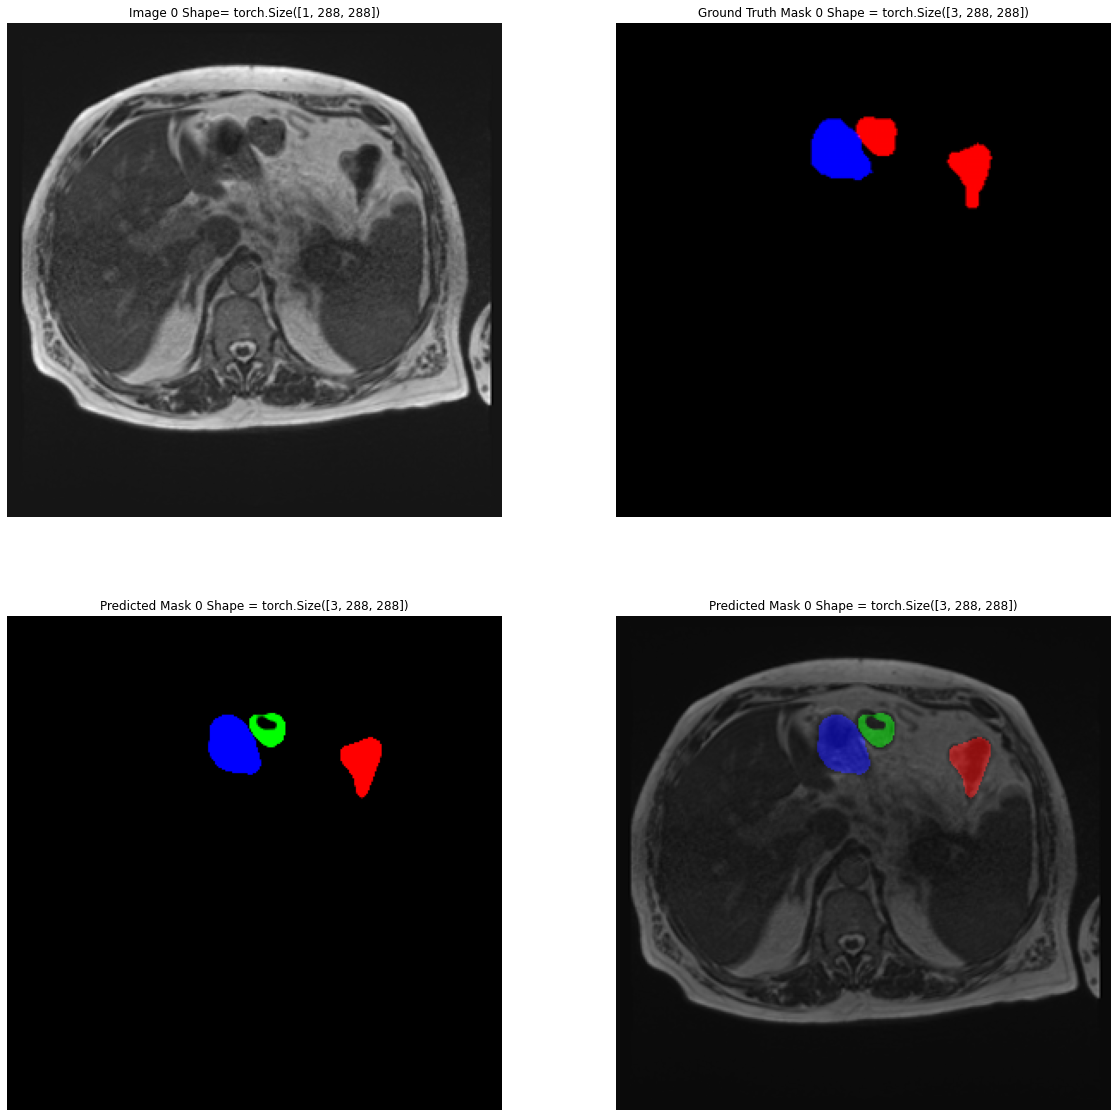

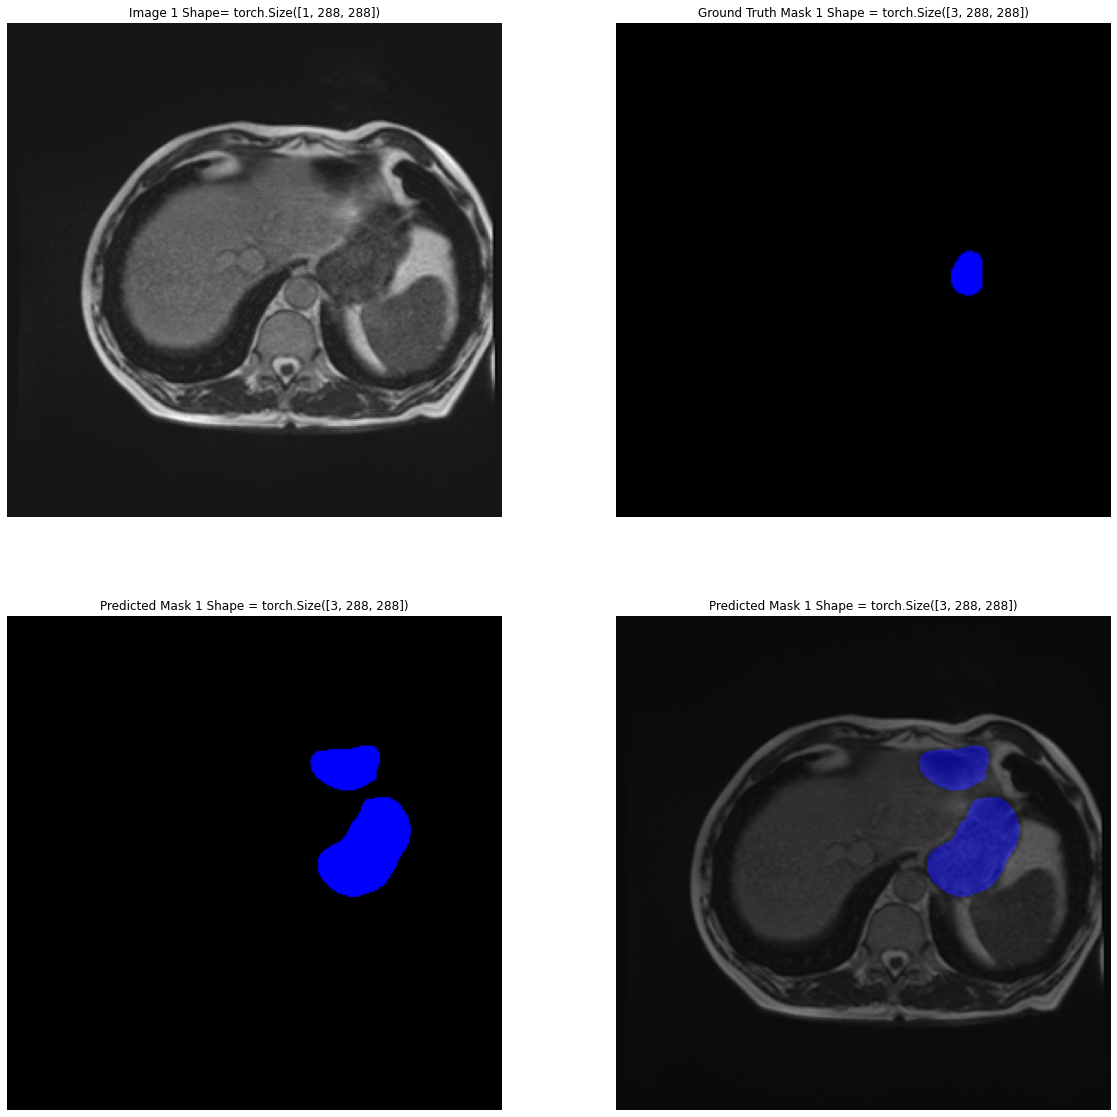

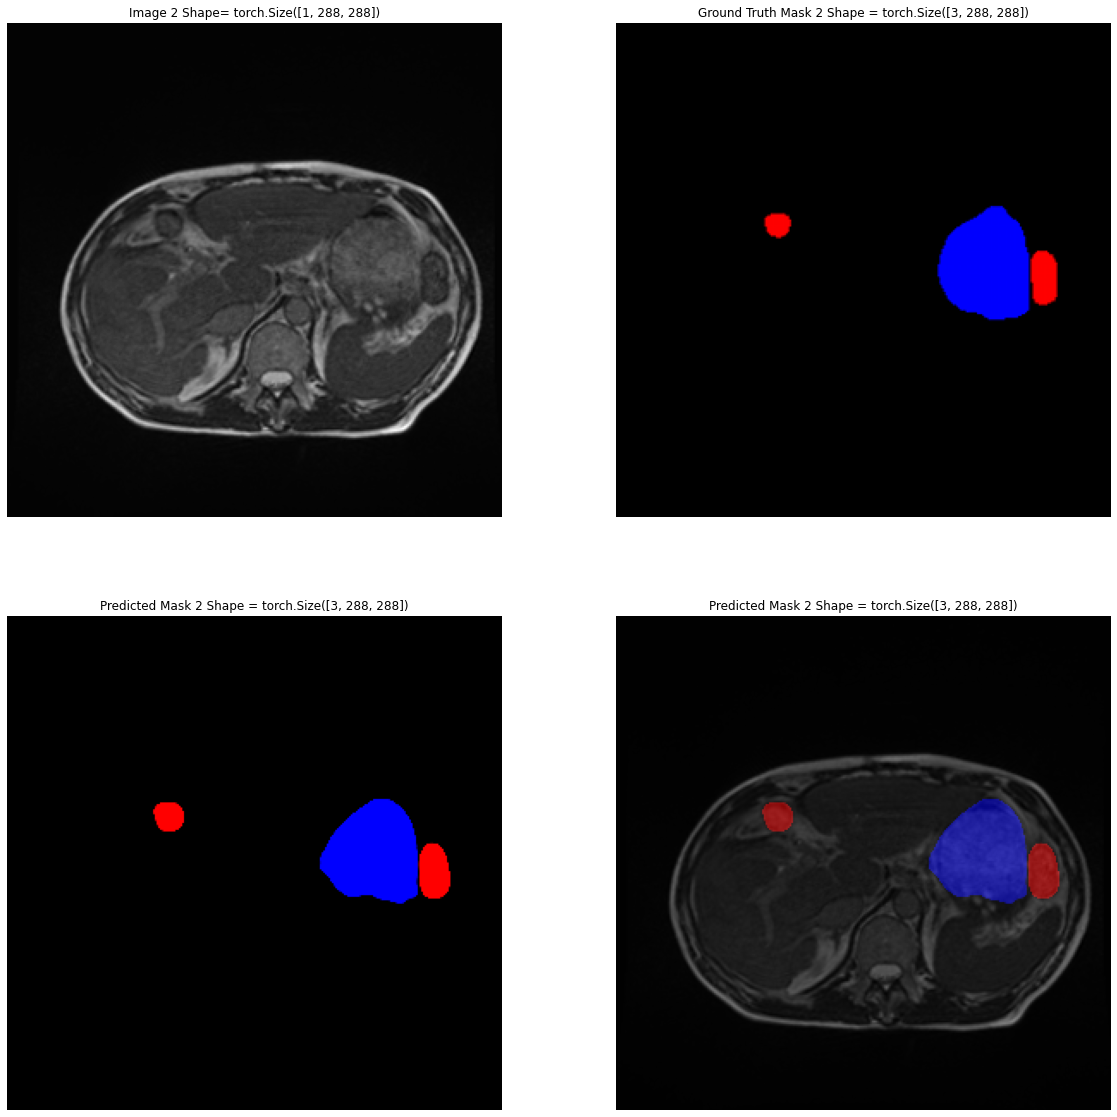

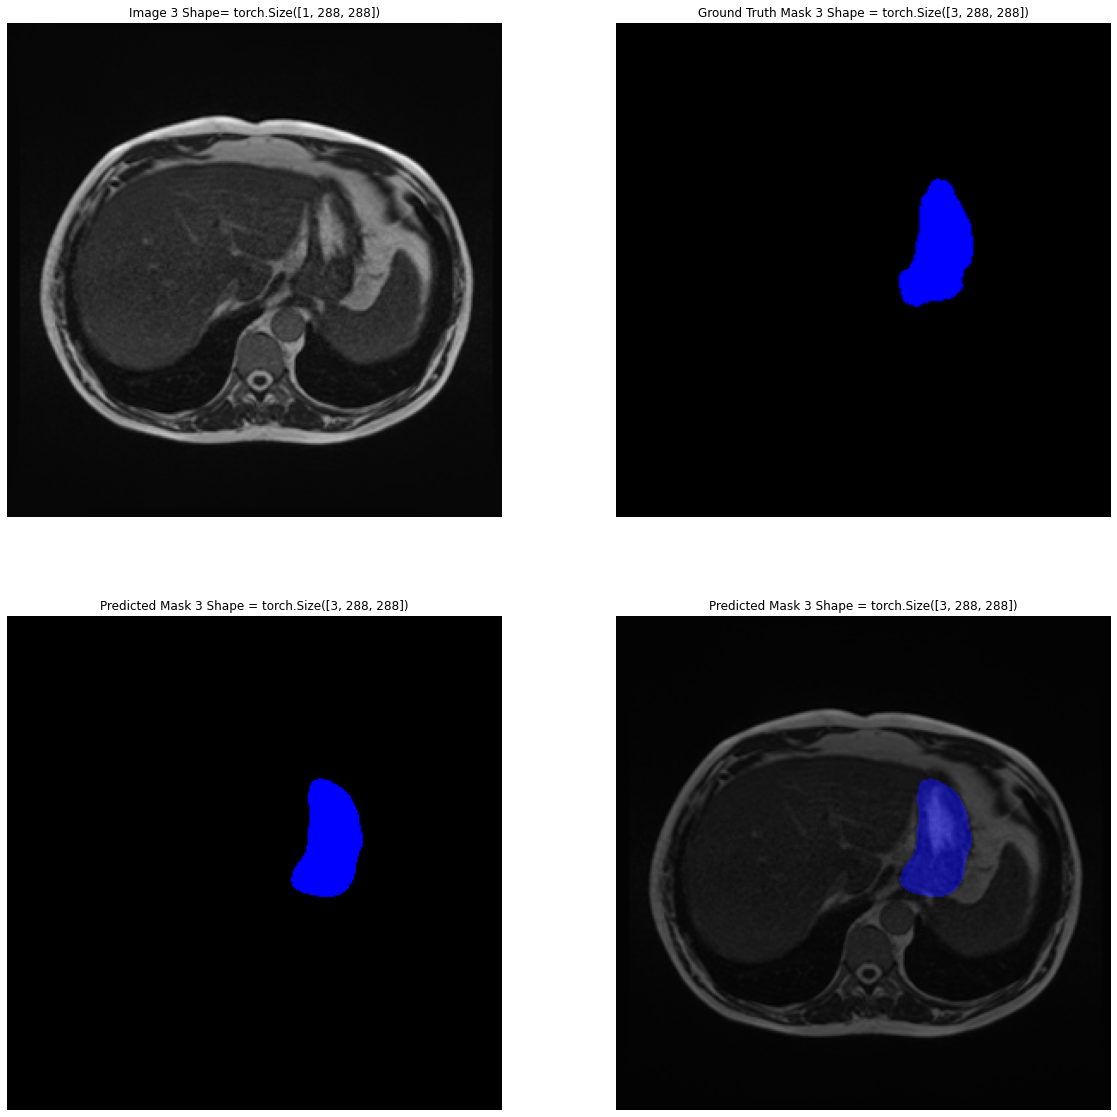

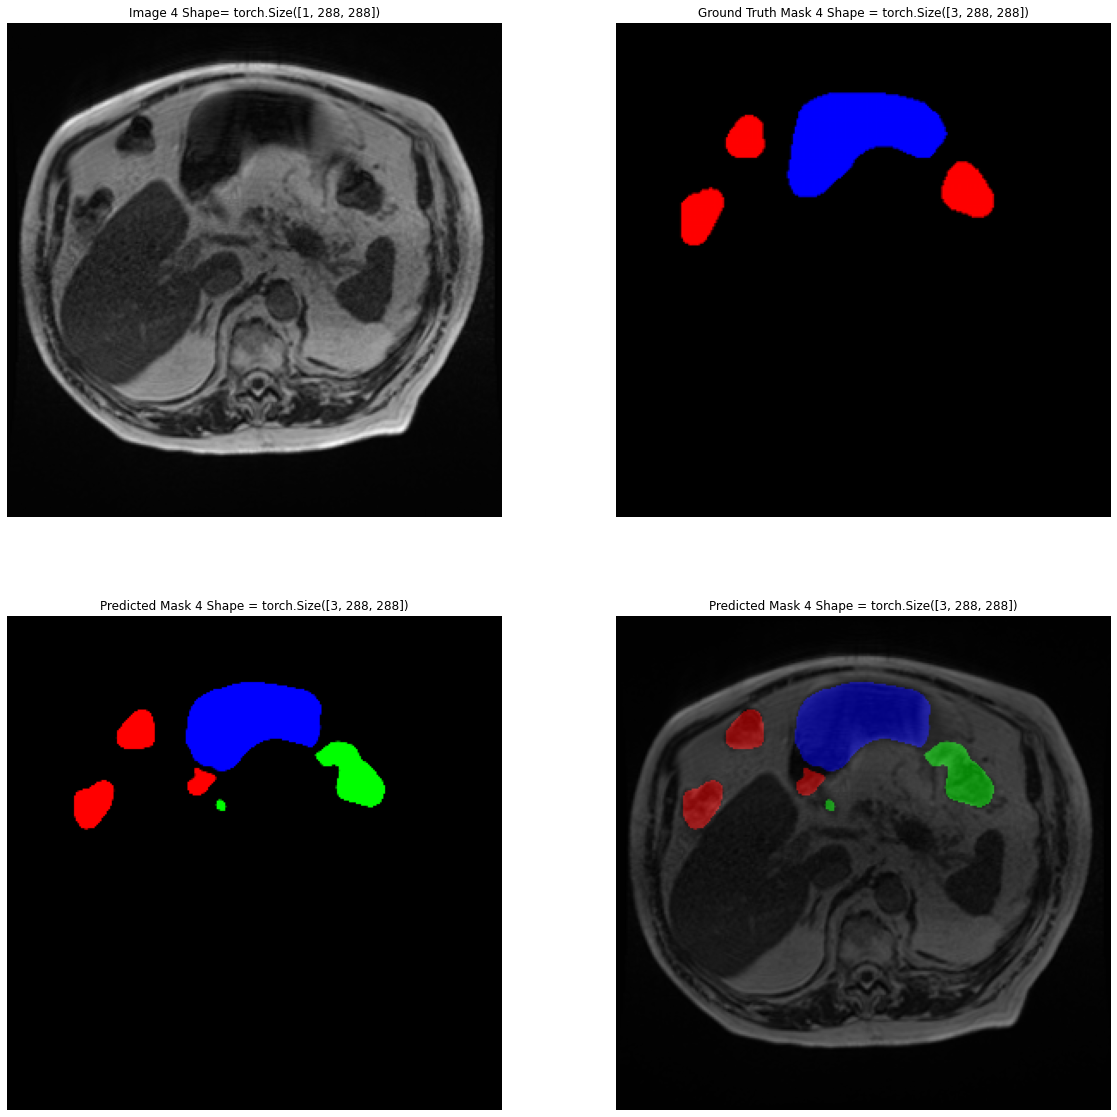

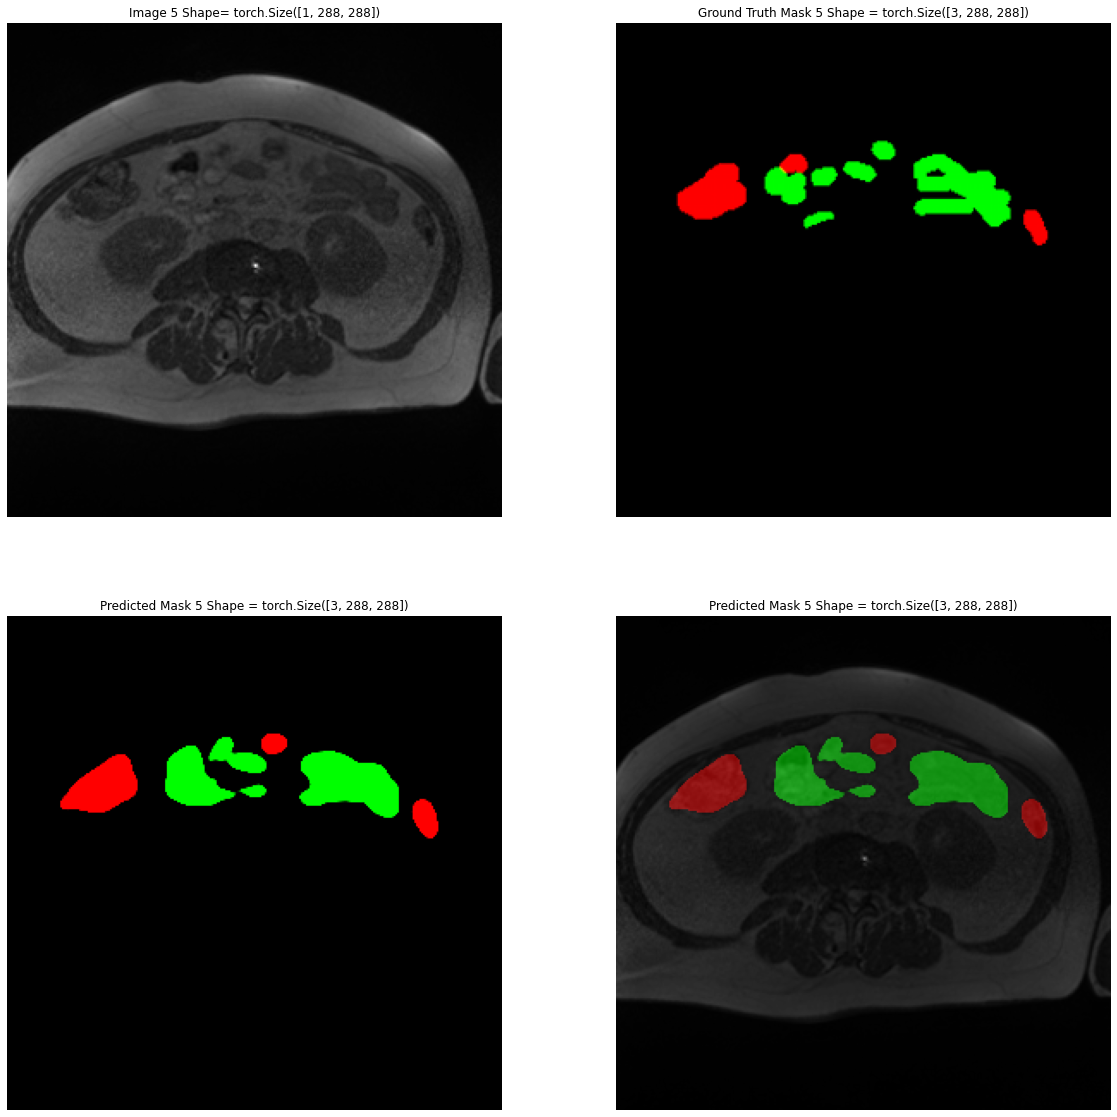

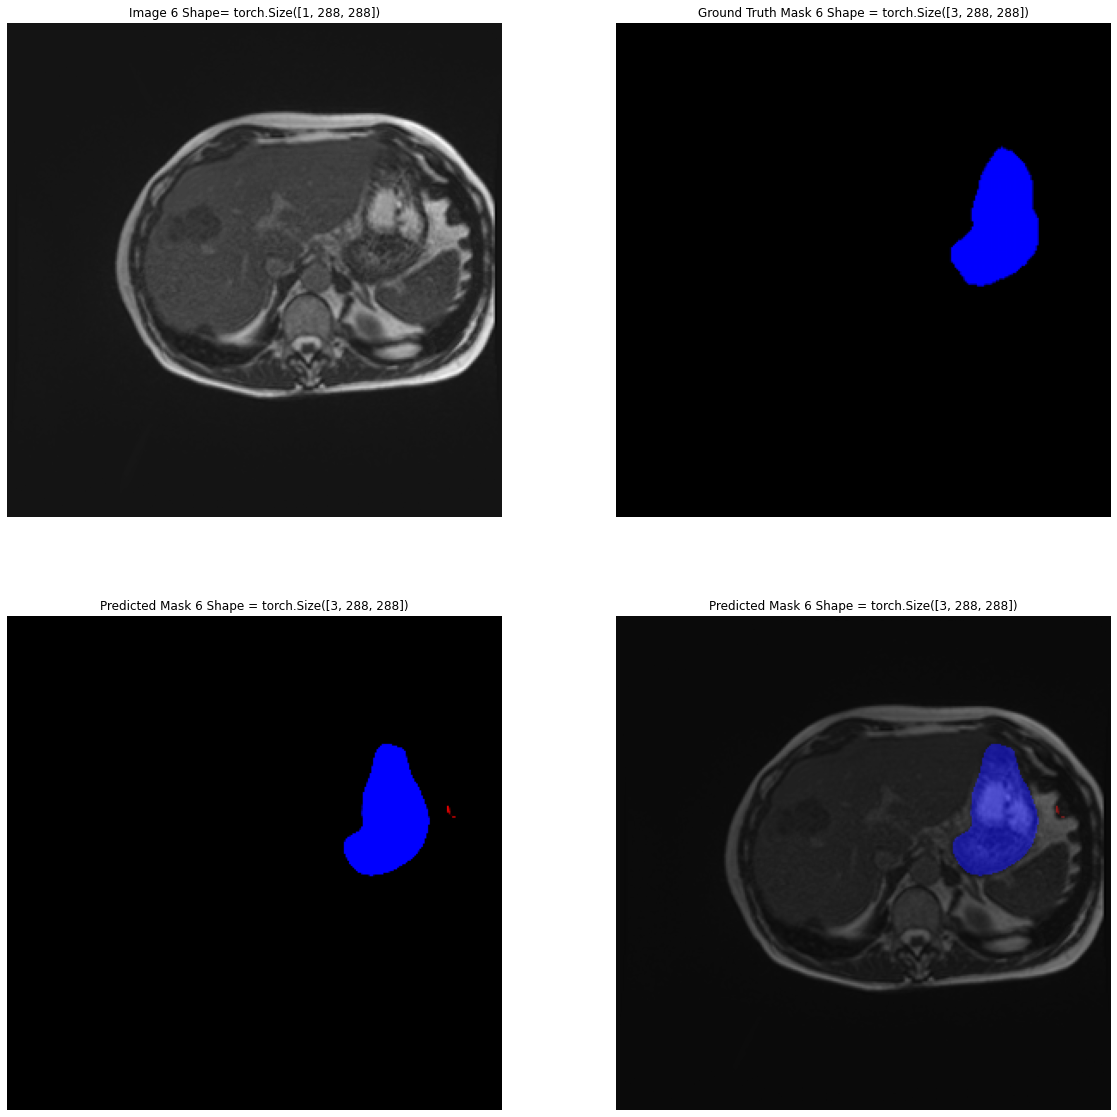

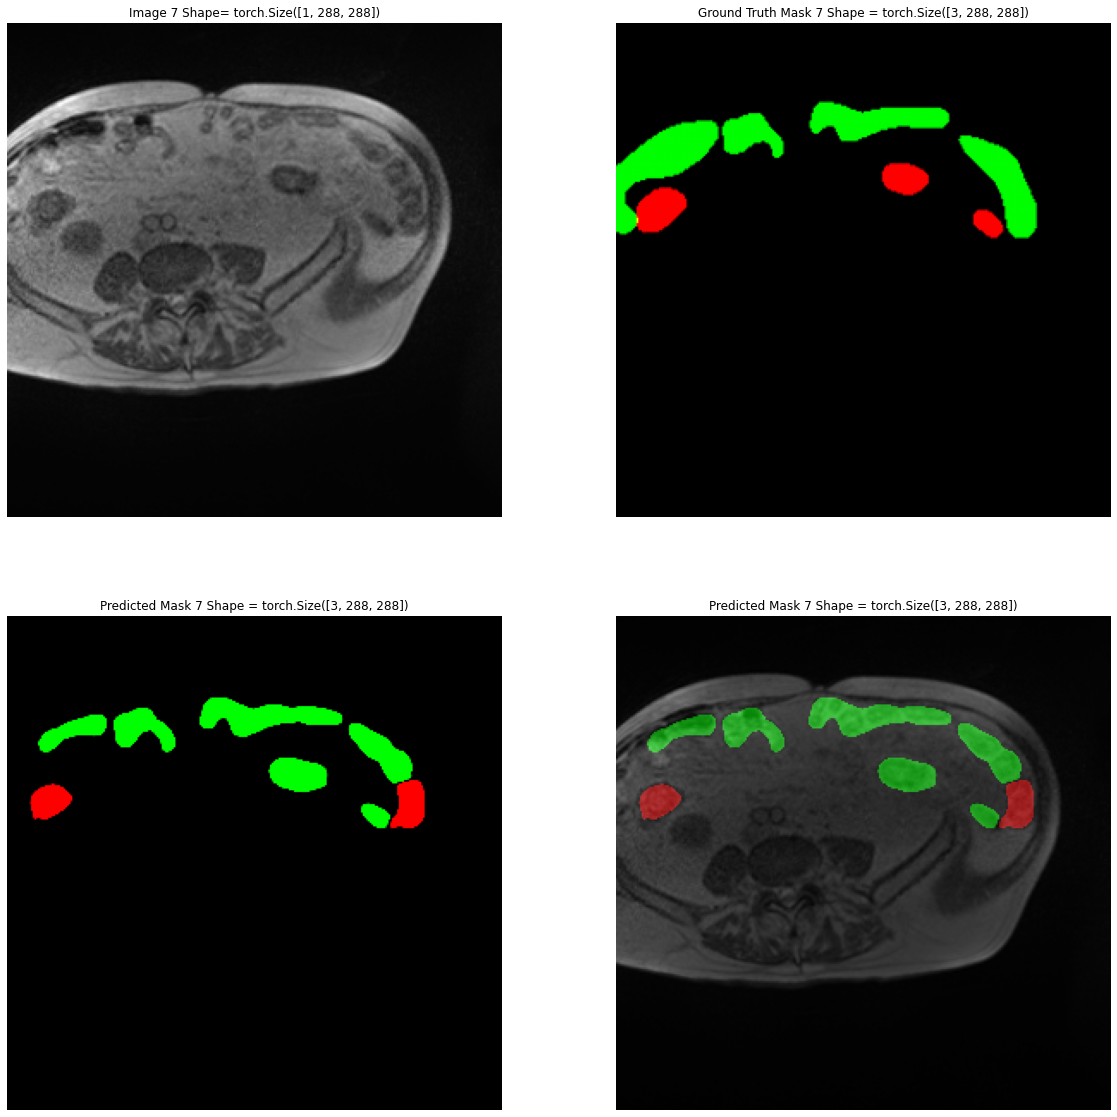

In [25]:
for idx in range(0,8):
    plot_result(data=data, output=output, idx=idx)

## Calculate the error metrics on the validation folds

In [ ]:

mean_metric = 0

for fold in range(0,n_folds):
    
    model = smp.Unet(
    encoder_name="efficientnet-b0",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3)                    # model output channels (number of classes in your dataset)
    
    model_in_str = MODEL_FOLDER+ "/" + "fold-" + str(fold) + '-' + model_file_base 
    print(model_in_str)
    model.load_state_dict(torch.load(model_in_str))
    model.to(torch.device(DEVICE))
    model.eval()

    train_dataset, valid_dataset = prepare_datasets(df2d, fold, train_transforms, valid_transforms)
    

    valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                                   batch_size=8,
                                                   num_workers=10,
                                                   pin_memory=True,
                                                   shuffle=True)
    
    

        
    validation_loss, validation_metric = validatefp32(valid_dataloader,
                                                      loss_fn,
                                                      metric_fn,
                                                      model)



    print('Fold-{}- Loss: {:.4f}, Metric = {:.3f}'.format(fold, validation_loss, validation_metric))
    
    mean_metric = mean_metric + validation_metric
    
print("Mean metric =",mean_metric)    